### Developing infrastructure for calculating rolling correlations over diff periods of time for combinations of asset pairs: (asset 1, asset 2, corr_window, business_date)

In [5]:
import os
import sys

import pandas as pd
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
from typing import Optional, Set

# Required to import other modules from this project, in folders such as utils/ or notebooks/
current_folder = os.getcwd()
project_root_folder = os.path.abspath(os.path.join(current_folder, ".."))
sys.path.append(project_root_folder)
# Import functionalities from other modules in this project
from utils.db_utils import *

# Load .env file for AWS RDS login credentials
from dotenv import load_dotenv
dotenv_path = os.path.join(project_root_folder, ".env")
load_dotenv(dotenv_path)

# Global variables
conn, cursor = connect_to_rds()

✅ Connected successfully!


In [70]:
import matplotlib.pyplot as plt

def plot_rolling_correlation(df_corr: pd.DataFrame):
    """
    Given a DataFrame with columns ['asset_1', 'asset_2', 'n_months', 'end_date', 'correlation'],
    this function creates a time series plot of the rolling correlation.
    """
    if df_corr.empty:
        print("DataFrame is empty. Nothing to plot.")
        return

    # Extract metadata for plot title
    asset_1 = df_corr["asset_1"].iloc[0]
    asset_2 = df_corr["asset_2"].iloc[0]
    n_months = df_corr["n_months"].iloc[0]

    # Sort by date in case it isn't sorted
    df_corr_sorted = df_corr.sort_values(by="end_date")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df_corr_sorted["end_date"], df_corr_sorted["correlation"], marker="o", linestyle="-")
    plt.title(f"Rolling {n_months}-month correlation between {asset_1} and {asset_2}")
    plt.xlabel("End Date")
    plt.ylabel("Correlation")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Generate unique pairs of assets. I might not need all of these, though

In [4]:
dates_query = """
select ticker from tbl_active_tickers
where is_active = TRUE;
"""

df_active_tickers = sql_query_as_df(dates_query, cursor)

In [5]:
# Dataframe -> series -> np array -> list
active_tickers = df_active_tickers["ticker"].values.tolist()

In [6]:
from itertools import combinations

In [7]:
# Get all unique combinations of (asset_1, asset_2) pairs
asset_pairs_unsorted = list(combinations(active_tickers, 2))
asset_pairs_sorted = [tuple(sorted((asset_1, asset_2))) for (asset_1, asset_2) in asset_pairs_unsorted]
asset_pairs_sorted

[('GLD', 'SPY'),
 ('NVDA', 'SPY'),
 ('SPY', 'TSLA'),
 ('SPY', 'TLT'),
 ('SLV', 'SPY'),
 ('GLD', 'NVDA'),
 ('GLD', 'TSLA'),
 ('GLD', 'TLT'),
 ('GLD', 'SLV'),
 ('NVDA', 'TSLA'),
 ('NVDA', 'TLT'),
 ('NVDA', 'SLV'),
 ('TLT', 'TSLA'),
 ('SLV', 'TSLA'),
 ('SLV', 'TLT')]

### Rolling correlation calculation function now

In [72]:
# Inputs for test data
asset_1 = "NVDA"
asset_2 = "TSLA"
min_end_date_str = "2020-01-01"
max_end_date_str = "2025-07-01"
n_months = 3

# Convert test inputs
date_str_format = "%Y-%m-%d"
min_end_date = datetime.strptime(min_end_date_str, date_str_format).date()
max_end_date = datetime.strptime(max_end_date_str, date_str_format).date()

min_start_date = min_end_date - relativedelta(months = n_months)

In [75]:
def get_daily_asset_returns(asset_1: str, asset_2: str, min_start_date: date, max_end_date: date) -> pd.DataFrame:

    returns_query = f"""
    select
        asset_1.business_date,
        asset_1.adj_close_pct_chg as asset_1_returns,
        asset_2.adj_close_pct_chg as asset_2_returns
    from tbl_daily_prod asset_1 join tbl_daily_prod asset_2
        on asset_1.business_date = asset_2.business_date
    where
        asset_1.ticker = '{asset_1}' and asset_1.business_date between '{min_start_date}' and '{max_end_date}'
        and asset_2.ticker = '{asset_2}' and asset_2.business_date between '{min_start_date}' and '{max_end_date}'
    order by asset_1.business_date;
    """

    conn, cursor = connect_to_rds()
    df_daily_returns = sql_query_as_df(returns_query, cursor)

    if df_daily_returns.empty:
        print(f"Error: Returns data for {asset_1} and {asset_2} between {min_start_date} and {max_end_date} is empty in tbl_daily_prod")
        sys.exit(1)

    min_returns_date = min(df_daily_returns["business_date"])
    max_returns_date = max(df_daily_returns["business_date"])

    if min_returns_date > min_start_date:
        print(f"Warning: Your input requires returns data going back to {min_start_date}, but returns data only goes back to {min_returns_date}")
    
    if max_returns_date > max_end_date:
        print(f"Warning: Your input requires returns data going up to {max_end_date}, but returns data only goes up to {max_end_date}")
    
    conn.close()

    return asset_1, asset_2, df_daily_returns

In [76]:
# Test get_daily_asset_returns
asset_1, asset_2, df_daily_returns = get_daily_asset_returns(asset_1, asset_2, min_start_date, max_end_date)

✅ Connected successfully!


In [77]:
df_daily_returns.head(n = 5)

,business_date,asset_1_returns,asset_2_returns
0,2020-01-02,NaN,NaN
1,2020-01-03,-1.632722,2.963325
2,2020-01-06,0.427923,1.925464
3,2020-01-07,1.235259,3.880055
4,2020-01-08,0.191318,4.920479


In [78]:
df_daily_returns.tail(n = 5)

,business_date,asset_1_returns,asset_2_returns
1369,2025-06-13,-2.089655,1.942904
1370,2025-06-16,1.915898,1.174265
1371,2025-06-17,-0.393946,-3.882964
1372,2025-06-18,0.943658,1.801802
1373,2025-06-20,-1.120429,0.034156


In [79]:
def calc_rolling_correlation(asset_1: str, asset_2: str, df_daily_returns: pd.DataFrame, n_months: int) -> pd.DataFrame:
   
    # First verify that the min_business_date and max_business_date are separated by more than n_months.  If not, crash the program

    # Now we loop backwards from most recent to most distance past
    # df_returns has 3 columns: business_date, asset_1_returns, asset_2_returns
    business_dates = df_daily_returns["business_date"]
    min_business_date = min(business_dates)

    # CHECK
    # for business_date in business_dates:
    #    print(f"business_date: {business_date}")

    business_dates_to_correlations = []

    for end_date in business_dates:

        # print(f"end_date: {end_date}")

        # For a given end_date, attempt to get the start_date of the correlation calculation.  If it is earlier than the oldest date, continue to the next end_date
        n_months_before_end_date = end_date - relativedelta(months = n_months)
        # print(f"n_months_before_end_date: {n_months_before_end_date}")

        if n_months_before_end_date >= min_business_date:

            start_date = max([d for d in business_dates if d <= n_months_before_end_date])

            df_between_start_end_date = df_daily_returns.loc[
                (start_date <= df_daily_returns["business_date"]) & (df_daily_returns["business_date"] <= end_date)
            ]

            corr = df_between_start_end_date["asset_1_returns"].corr(df_between_start_end_date["asset_2_returns"])

            # print(f"start_date: {start_date}")
            # print(f"correlation: {corr}")
            # print("\n")
            
            business_date_to_correlation = {
                "asset_1": asset_1,
                "asset_2": asset_2,
                "n_months": n_months,
                "end_date": end_date,
                "correlation": corr
            }

            business_dates_to_correlations.append(business_date_to_correlation)

        else:
            # print(f"n_months_before_end_date is too far back: {n_months_before_end_date}. Skipping")
            # print("\n")
            continue
    
    # TODO: If I will just directly insert into the PostgreSQL database after this, there is no need to convert into a Pandas dataframe, because I will just convert into a list of dict before insertion
    df_correlation_time_series = pd.DataFrame(business_dates_to_correlations)

    return df_correlation_time_series

In [81]:
df_correlation_time_series = calc_rolling_correlation(asset_1, asset_2, df_daily_returns, n_months)

In [82]:
df_correlation_time_series

,asset_1,asset_2,n_months,end_date,correlation
0,NVDA,TSLA,3,2020-04-02,0.538361
1,NVDA,TSLA,3,2020-04-03,0.523566
2,NVDA,TSLA,3,2020-04-06,0.535719
3,NVDA,TSLA,3,2020-04-07,0.524675
4,NVDA,TSLA,3,2020-04-08,0.523548
...,...,...,...,...,...
1306,NVDA,TSLA,3,2025-06-13,0.777317
1307,NVDA,TSLA,3,2025-06-16,0.778314
1308,NVDA,TSLA,3,2025-06-17,0.776543
1309,NVDA,TSLA,3,2025-06-18,0.775816


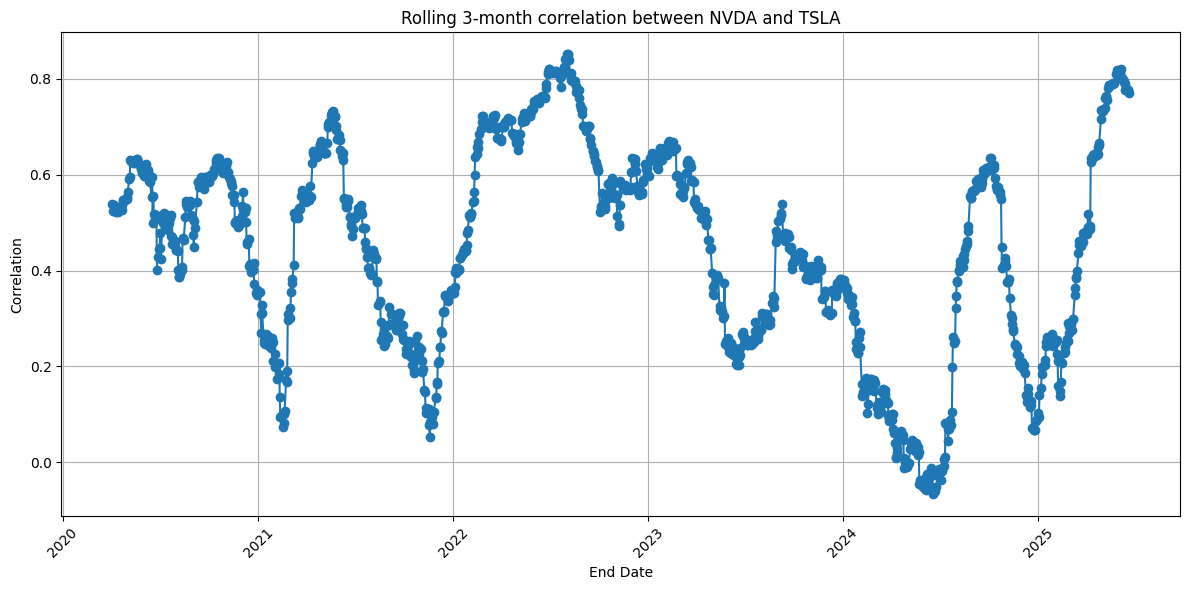

In [83]:
plot_rolling_correlation(df_correlation_time_series)